In [111]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import random
import pandas as pd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import json as js
from scipy.stats import truncnorm
import seaborn as sns
sns.set_style({'axes.facecolor': 'white',
         'axes.edgecolor': 'black',
        'axes.grid': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'figure.facecolor':"white",
        'axes.labelcolor': '.15',
         'grid.color': 'white',
         'grid.linestyle': '-',
         'text.color': '.15',
         'xtick.color': '.15',
         'ytick.color': '.15',
        'patch.edgecolor': 'white',})
from tqdm import tqdm

## Networks

In [112]:
n = 1000
m = 4000
def constrained_sum_sample_pos(n, m):
    dividers = sorted(random.sample(range(1, m), n - 1))
    return [a - b for a, b in zip(dividers + [m], [0] + dividers)]

def random_graph_revised(n, m):
    degree_squence = constrained_sum_sample_pos(n, m)
    node_ids = list(range(n))
    edge_list = []
    for i in node_ids:
        non_self = [j for j in node_ids if i!= j]
        targets = random.sample(non_self, degree_squence[i]) 
        edges_of_n = [(i,target) for target in targets]
        edge_list = edge_list+ edges_of_n
    G = nx.DiGraph()
    G.add_edges_from(edge_list)
    return G

G = random_graph_revised(n, m)

## Social Media

In [113]:
### social media 
class SocialMedia:
    def __init__(self, n = 100, m = 400):
        self.p = .5
        #self.q = .5
        self.n = n
        self.m = m
        self.l = np.random.randint(2, 10, n)
        self.G = random_graph_revised(self.n,self.m) 
        ### need to make sure there is no node that has zero out degree. 
        self.O = np.random.uniform(-1, 1, self.n)
        self.Opinions_db = {"Time_0": copy.deepcopy(self.O)}#pd.DataFrame(self.O, columns= ["Time_0"]) ### uniform distribution
        self.Message_db = pd.DataFrame(columns = ["original_poster", "rt_poster","content", "rt_status"])
        self.Message_db["rt_status"] = self.Message_db["rt_status"].astype(bool) #<--deal with warning
        self.Network_db = {"Time_0": list(self.G.edges())}
        self.ME_db = pd.DataFrame(columns = ["uid", "Time", "index", "effects"])
        self.ME_db["effects"] = self.ME_db["effects"].astype(bool) #<--deal with warning

        
    def screen_size(self, uid):
        l = self.l[uid] + np.random.randint(-2, 3) ## hidden parameter
        return l
            
    def make_screen(self, uid, l, sub, include_media = True):
        friends = list(self.G.successors(uid))
        if include_media :
            friends = friends + sub
        #print
        repost_by_friend = self.Message_db.rt_poster.isin(friends)
        #print(repost_by_friend)
        screen = self.Message_db[repost_by_friend].tail(l)
        if len(screen)>0:
            return screen
        else:
            return None
        
    def get_recent_o(self, uid):
        return self.O[uid]

    def get_recent_neighors(self, uid):
        return self.G.successors(uid)
    
    def add_edge(self, uid, new_fri):
        self.G.add_edge(uid, new_fri)

    def remove_edge(self, uid, foe_target):
        self.G.remove_edge(uid, foe_target)
        
    def add_message(self, message):
        self.Message_db = pd.concat([self.Message_db,message], ignore_index = True, axis = 0)
    #########    
    def update_Opinions_db(self, uid, new_o, t):
        if new_o:
            self.O[uid] = new_o
        self.Opinions_db["Time_"+str(t+1)] = copy.deepcopy(self.O)
        #self.Opinions_db = pd.concat([self.Opinions_db, pd.DataFrame(self.O, columns= ["Time_"+str(t)])], axis =1 )

    def update_Network_db(self, t):
        self.Network_db["Time_"+str(t+1)] = copy.deepcopy(list(self.G.edges())) 
    
    def update_ME_db(self, t, uid, fri, foe):
        if fri is not None:
            #print(fri)
            fri = fri.reset_index()
            fri["effects"] = True 
            fri["uid"] = uid
            fri["Time"] = t + 1
            fri_record = fri[["uid", "Time", "index", "effects"]]
            #print(fri_record)
            self.ME_db = pd.concat([self.ME_db, fri_record], axis= 0, ignore_index=True)
            #print(self.ME_db)
        if foe is not None:
            foe = foe.reset_index()
            foe["effects"] = False
            foe["uid"] = uid
            foe["Time"] = t + 1 
            foe_record = foe[["uid", "Time", "index", "effects"]]
            self.ME_db = pd.concat([self.ME_db, foe_record], ignore_index= True)
        #return fri_record, foe_record
        

## User

In [114]:
class User():
    def __init__ (self, uid, eta, miu, o, G, subs, mids):
        self.uid = uid
        self.eta = eta
        self.miu = miu
        self.o = o
        self.G = G
        self.f = self.G.successors(uid)
        self.subs = subs
        self.mids = mids
        self.me_fri_subs = set(self.f).union({self.uid}).union(self.subs)


    def find_fri(self, screen):
        if screen is not None:
            screen["fri_or_foe"] = np.where(np.abs(screen.content.values-self.o)<self.eta, True, False)
            fri = screen[screen.fri_or_foe == True]
            if len (fri) >0:
                return fri
            else:
                return None
    
    def find_foe(self, screen):
        if screen is not None:
            screen["fri_or_foe"] = np.where(np.abs(screen.content.values-self.o)<self.eta, True, False)
            foe = screen[screen.fri_or_foe == False]
            if len (foe) >0:
                return foe
            else:
                return None
 
    def update_opinion(self,fri, rand):
        if fri is not None:
            social_influence = self.miu * np.mean(fri.content - self.o)
            new_opinion = self.o+ social_influence + (np.random.random()*2-1)*rand
            ##self.o = new_opinion >>> this is somewhat critical: including this that means all of posts, friending, and unfriending will based on the new opinion
            return new_opinion

    def generate_post(self, fri, p = .5):
        if np.random.random()< p:
            if fri is not None:
                rt = fri.sample(1)
                rt["rt_poster"] = self.uid
                rt["rt_status"] = True
                rt.drop(["fri_or_foe"], axis = 1, inplace = True)
                #print("Agent {} repost {}".format(str(self.uid), str(rt.original_poster)))
                return rt    
        else:
            self_tw = pd.DataFrame({"original_poster": [self.uid], "rt_poster": [self.uid], "content": [self.o], "rt_status":[False]})
            #print("Agent {} post about self".format(str(self.uid)))
            return self_tw

    def screen_candidates(self, candidates, output = "mix"):
        if candidates is not None and len(candidates)>0:
            if output == "agent":
                candidates = [int(i) for i in candidates if str(i)[0]!="m"]
                #print("agent", candidates)
            if output == "media":
                candidates = [i for i in candidates if str(i)[0] =="m"]
                #print("media", candidates)
            if len(candidates)>0:
                target = np.random.choice(list(candidates))
                #print(target)
                if str(target)[0]!= "m":
                    target = int(target)
                return target

    
    def friend_repost(self, fri, output = "mix"): 
        if fri is not None:
            original_posters = set(fri.original_poster.values)- self.me_fri_subs
            candidate =  self.screen_candidates(original_posters, output= output)
            return candidate
        
    def friend_recommend(self, Message_db, output= "mix"):
        recent = Message_db[~Message_db.rt_poster.isin(self.me_fri_subs)].tail(21) ### hidden parameter
        #print("Recent message board", recent)
        if len(recent) >0:
            #recent["fri_or_foe"] = np.where(np.abs(recent.content.values-self.o) < self.eta, True, False)
            recommend = self.find_fri(recent) #recent[recent.fri_or_foe == True]
            if recommend is not None:
                if len(recommend) > 0:
                    candidate =  self.screen_candidates(recommend.rt_poster, output= output)
                    #print("candidate", candidate)
                    return candidate

    def friend_random(self, output = "mix"):
        non_friends = list(set(self.G.nodes).union(set(self.mids)) - self.me_fri_subs)
        candidate = self.screen_candidates(non_friends, output= output)
        #print("random", candidate)
        if candidate is None:
            if output == "media":
                return np.random.choice(self.mids) ### exception        
        else:
            return candidate

        
    def find_unfriend(self, foe):
        #if np.random.random()<self.p:
        if foe is not None:
            if len(foe)>0:
                target_foe = np.random.choice(foe["rt_poster"])
                return target_foe
    
    def find_friend(self, fri, Message_db, output, print_method =False):
        new_friend = None
        if fri is not None and len(fri) >0:
            new_friend = self.friend_repost(fri, output = output)
            method = "repost"
        if new_friend is None:
            new_friend = self.friend_recommend(Message_db, output = output)
            method = "recommend"
        if new_friend is None:
            new_friend = self.friend_random(output = output)
            method = "random"
        if new_friend is None:
            print(str(self.uid), "Warning: NOT finding a random/repost/recommend {}".format(output))
        elif print_method:
            print(self.uid, "found", new_friend, "through", method)
        if self.uid == new_friend:
            print(self.uid, "Self loop warning", method)
        return new_friend
                          

## Mass Media

In [115]:
class MassMedia():
    def __init__(self, p,  s, n, agents = 100):
        self.p = p
        self.s = s
        self.n = n
        self.agents = agents
        self.mids = ["m"+str(i) for i in range(n)]
        self.shares = self.init_share()
        self.init_subs = self.split_list()#self.random_split() #
        self.subs = {self.mids[i]:self.init_subs[i] for i in range(n)} #self.split_list()
        self.Subs_db = {"Time_0": copy.deepcopy(self.subs)}
        #self.Message_db = {"Time_0": {self.mids[i]:[] for i in range(n)}}
        
    def init_share(self):
        holders = np.ones (self.agents)
        splits = np.random.choice(np.arange(1,self.agents), self.n-1, replace=False)
        splits = [0] + list(sorted(splits)) + [self.agents]
        res = [int(np.sum(holders[splits[i]:splits[i+1]])) for i in range(self.n)]
        #print(res)
        return res 
    
    def split_list(self): ### No overlap
        start = 0
        end = 0
        output = []
        aud_size =  int(np.ceil(self.agents * self.s))
        aud_ids = np.random.choice(np.arange(self.agents), aud_size, replace= False)
        sizes = np.int32(np.ceil(np.array(self.shares)*self.s))
        for size in sizes:
            end += size
            output.append(aud_ids[start:end].tolist())
            start = end
        #print(output)
        return output
    
    def random_split(self): ## With possible overlap
        aud_size =  int(np.ceil(self.agents * self.s))
        aud_ids = np.random.choice(np.arange(self.agents), aud_size, replace= False)
        sizes = np.int32(np.ceil(np.array(self.shares)*self.s))
        return [np.random.choice(aud_ids, size, replace= False) for size in sizes ]
    
    def media_message(self, mid, Os, d = .25):
        if np.random.rand() < self.p:
            recent = self.Subs_db[list(self.Subs_db.keys())[-1]]
            v = np.mean(Os[recent[mid]]) + d*(np.random.rand()*2 -1)
            post = pd.DataFrame({"original_poster": [mid], "rt_poster": [mid], "content": [v], "rt_status":[False]})
            return post
        else:
            return None
    
    def find_subs(self, uid):
        #print(self.subs)
        subs = [k for k, v in self.subs.items() if uid in v]
        return subs
        
    def cancel(self, uid, foe_target):
        self.subs[foe_target].remove(uid)
    
    def subscribe(self, uid, fri_target):
        if uid not in self.subs[fri_target]:
            self.subs[fri_target].append(uid)

    def update_Sub_DB(self, t):
        #print(self.subs)
        self.Subs_db["Time_{}".format(t)] =  copy.deepcopy(self.subs)


        

## Actitivty

In [116]:
def send_media_message(sm, md, Os, include_media = True):
    if include_media:
        for mid in md.mids:
            #print(med_ms)
            ms = md.media_message(mid, Os)
            if ms is not None:
                sm.add_message(ms) 

def sample_user(sm):
    uid = np.random.randint(sm.n)
    l = sm.screen_size(uid)
    #print(l)
    if l == 0:
        return None, 0
    else:
        return uid, l

def user_activity(uid, sm, md, eta, miu, l, subs,  rand, include_media):
    o = sm.get_recent_o(uid)
    subs = md.find_subs(uid)
    user = User(uid, eta, miu, o, sm.G, subs, md.mids)
    screen = sm.make_screen(user.uid, l  , user.subs, include_media = include_media)
    fri = user.find_fri(screen)
    foe = user.find_foe(screen)
    new_o = user.update_opinion(fri, rand = rand)
    new_post = user.generate_post(fri)
    return user, fri, foe,  new_o, new_post


def update_network(user, prob_rewire, fri, foe, md, sm, mix = False):
    if np.random.random() < prob_rewire: 
        if foe is not None:
            foe_target = user.find_unfriend(foe)
            if str(foe_target)[0] == "m":
                md.cancel(user.uid, foe_target)
                #print(user.uid, "cancel" , foe_target)
                if not mix:
                    fri_target = user.find_friend(fri, sm.Message_db, output = "media")
                    md.subscribe(user.uid, fri_target)
            else:
                sm.remove_edge(user.uid, foe_target)
                #print(user.uid, "unfollow" , foe_target)
                if not mix:
                    fri_target = user.find_friend(fri, sm.Message_db, output = "agent")
                    sm.add_edge(user.uid, fri_target)
            if mix:
                fri_target = user.find_friend(fri, sm.Message_db, output = "mix", print_method = False)
                if str(fri_target)[0] == "m":
                    md.subscribe(user.uid, fri_target)
                else:
                    sm.add_edge(user.uid, fri_target)

## Sim

In [117]:
def sim(s, N, eta,
        p =.5,
        mix = False, 
        include_media = True,
        effect_record = True, 
        n = 100, m = 400, 
        T = 10000, 
        miu = .3, 
        prob_rewire = .3, 
        rand =.2):  #rand,
    sm = SocialMedia(n= n, m = m) 
    md = MassMedia(p, s, N)
    for t in tqdm(np.arange(T), desc = "Run: "): #np.arange(T):
        Os = sm.Opinions_db[list(sm.Opinions_db.keys())[-1]]
        send_media_message(sm, md, Os, include_media)
        uid, l = sample_user(sm)
        if uid:
            #print(uid, l)
            subs = md.find_subs(uid)
            user, fri, foe, new_o, new_post = user_activity(uid, sm, md, eta, miu, l, subs, rand, include_media)
            sm.add_message(new_post)
            sm.update_Opinions_db(uid, new_o, t)
            if effect_record == True:
                sm.update_ME_db(t, uid, fri, foe)
            update_network(user, prob_rewire, fri, foe, md, sm, mix = mix)
            sm.update_Network_db(t)
            md.update_Sub_DB(t)
    opinions = pd.DataFrame(sm.Opinions_db) 
    messages  =sm.Message_db
    messages.original_poster = messages.original_poster.astype(str)
    messages.rt_poster = messages.rt_poster.astype(str)
    networks = js.dumps(sm.Network_db) 
    effects = sm.ME_db 
    screensizes = js.dumps([int(x) for x in sm.l]) 
    subscriptions = js.dumps(md.Subs_db)
    return opinions, messages, networks, effects, screensizes, subscriptions

In [118]:
s = .5
N = 2
eta = .2
res = sim(s, N, eta, T = 100)

Run: 100%|██████████| 100/100 [00:00<00:00, 279.54it/s]


In [110]:
res[0]

,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_91,Time_92,Time_93,Time_94,Time_95,Time_96,Time_97,Time_98,Time_99,Time_100
0,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,...,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228,0.340228
1,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,...,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670,-0.930670
2,-0.880743,-0.880743,-0.880743,-0.880743,-0.880743,-0.880743,-0.880743,-0.880743,-0.880743,-0.880743,...,-0.683660,-0.683660,-0.683660,-0.683660,-0.683660,-0.683660,-0.683660,-0.683660,-0.683660,-0.683660
3,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,...,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881,0.761881
4,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,...,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003,-0.808003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,...,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925,-0.931925
96,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,...,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568,0.786568
97,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,...,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419,-0.915419
98,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,...,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171,0.341171


In [9]:
def vis(sm, s, N ,eta):
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))
    axes = axes.flatten()
    data = pd.DataFrame(sm.Opinions_db)
    data.T.plot(figsize = (20,10), ax = axes[0])
    axes[0].legend().remove()
    axes[0].set_xlabel("Values")
    sns.heatmap(data.sort_values(by = data.columns[-1]), ax = axes[1])
#axes[1].set_title("Baseline", fontsize = 26)
    axes[1].set_ylabel("Agent Id")
    axes[1].set_xlabel("Time steps")
#axes[1].set_xticks(np.arange(10))
    axes[1].set_xticklabels([])
#axes[1].set_title("Baseline Consensus", fontsize = 26)
    sns.histplot(data["Time_0"], bins = 10, ax = axes[2], kde= True)
    sns.histplot(data[data.columns[-1]], bins = 10, ax = axes[3], kde = True, color = "orange")
#plt.suptitle("N = {}, p = {}, s = {}".format(str(N), str(p), str(s)), y = .95, fontsize = 20)
    plt.suptitle(f"Share: {str(s)}  Num_media: {str(N)}: Tolerance: {str(eta)} ", y = .95, fontsize = 20)
    plt.show()
    return fig

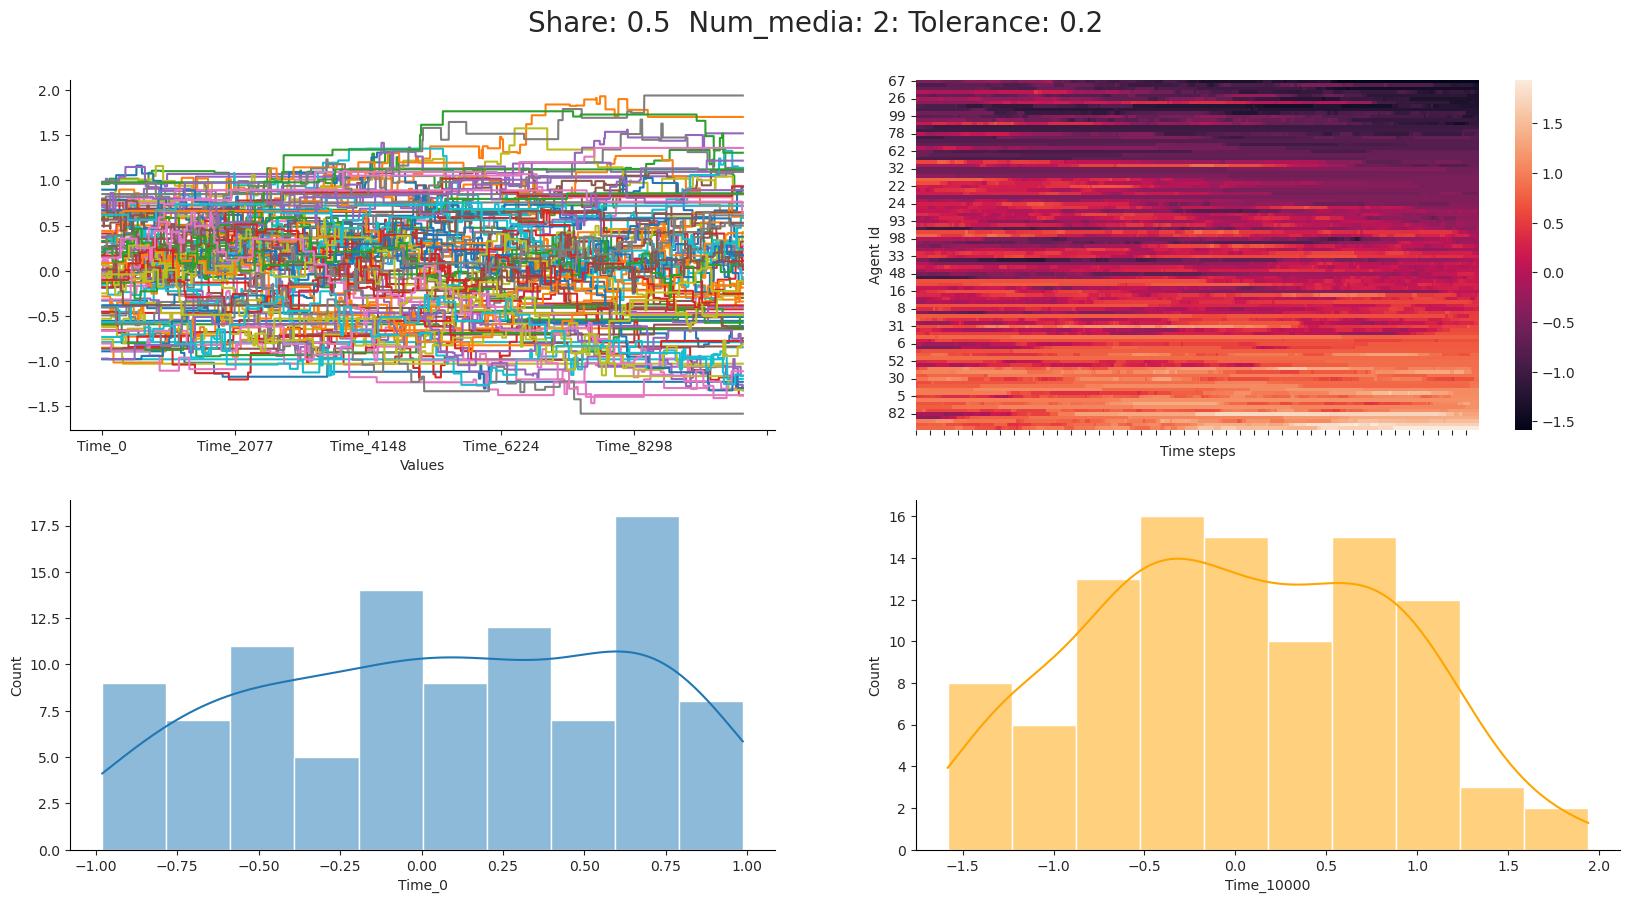

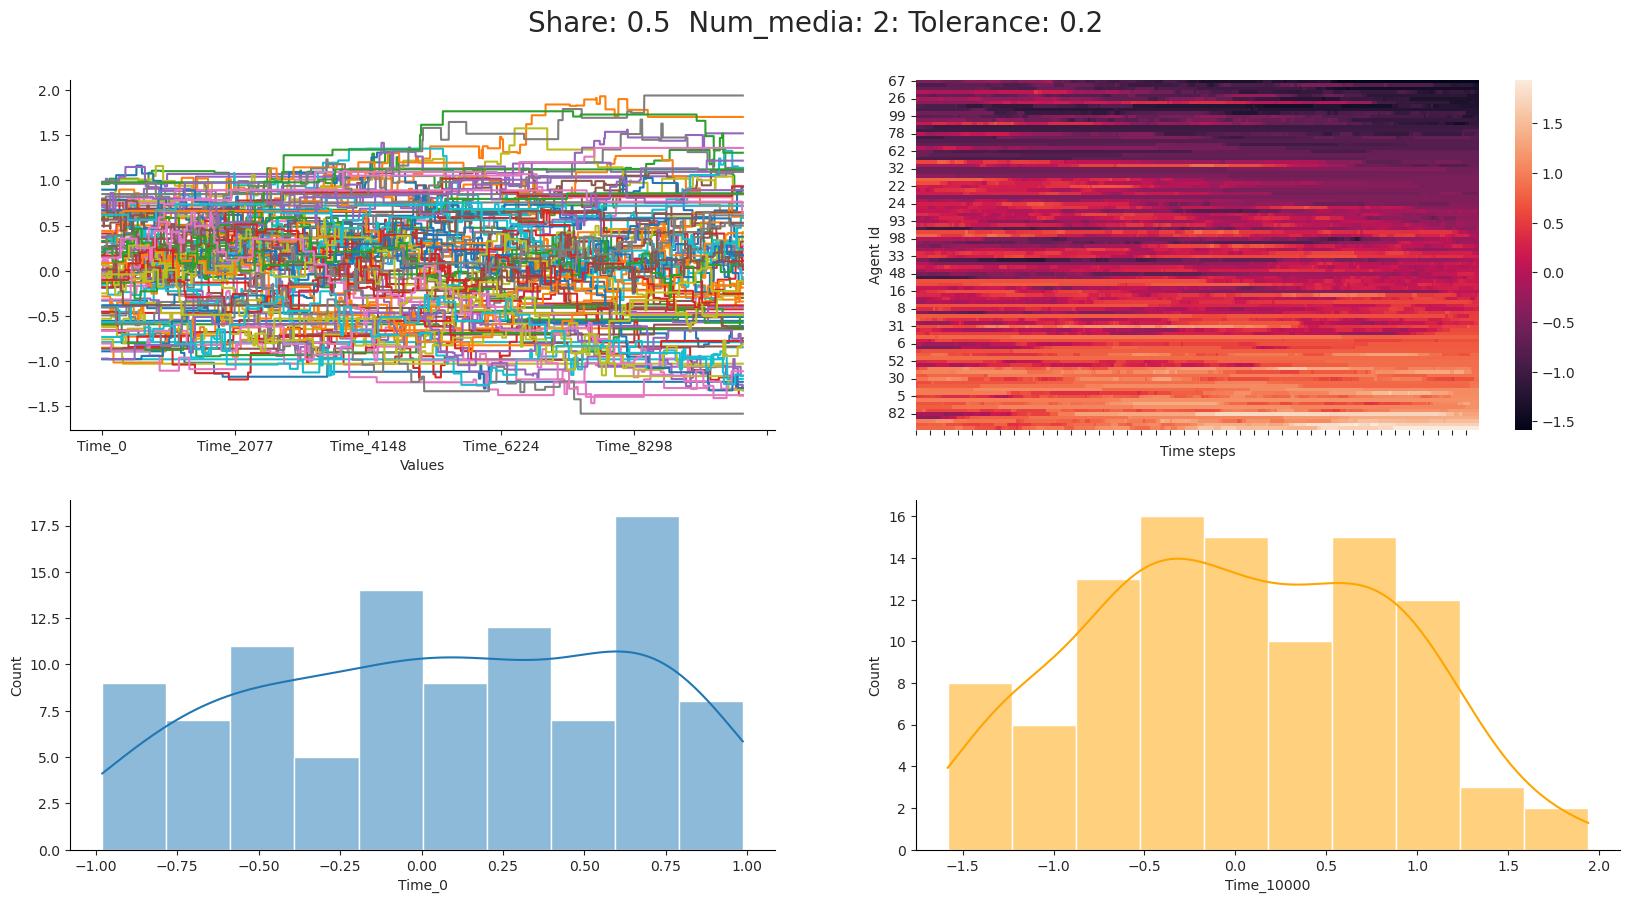

In [10]:
vis(sm, s, N, eta)

In [99]:
opinions = pd.DataFrame(sm.Opinions_db) 
messages =sm.Message_db 
networks = js.dumps(sm.Network_db) 
effects = sm.ME_db
screensizes = js.dumps([int(x) for x in sm.l]) 
subscriptions = js.dumps(md.Subs_db)

In [104]:
messages

,original_poster,rt_poster,content,rt_status
0,m0,m0,-0.129485,False
1,m1,m1,-0.258364,False
2,m0,m0,-0.031219,False
3,m1,m1,-0.034030,False
4,18,18,0.746864,False
...,...,...,...,...
166,83,29,-0.565894,True
167,m0,m0,-0.093776,False
168,m1,m1,-0.070551,False
169,m0,m0,-0.141969,False


Text(0.5, 0.95, 'Baseline (No Media)')

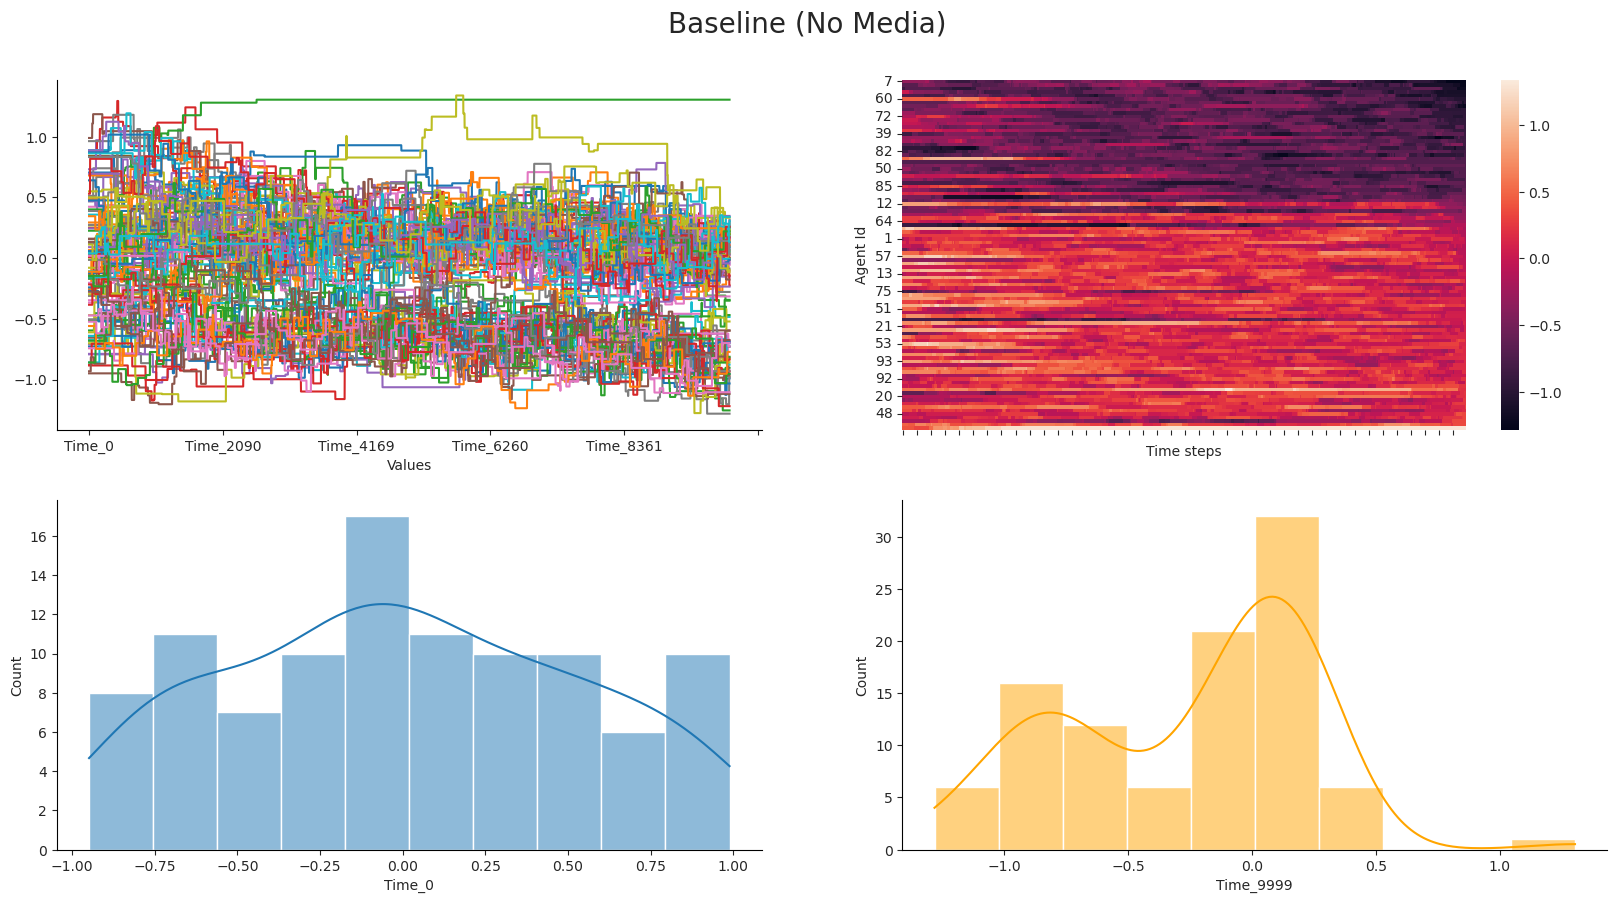

In [8]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()
pd.DataFrame(sm.Opinions_db).T.plot(figsize = (20,10), ax = axes[0])
axes[0].legend().remove()
axes[0].set_xlabel("Values")
sns.heatmap(pd.DataFrame(sm.Opinions_db).sort_values(by = "Time_{}".format(str(T-1))), ax = axes[1])
#axes[1].set_title("Baseline", fontsize = 26)
axes[1].set_ylabel("Agent Id")
axes[1].set_xlabel("Time steps")
#axes[1].set_xticks(np.arange(10))
axes[1].set_xticklabels([])
#axes[1].set_title("Baseline Consensus", fontsize = 26)
sns.histplot(pd.DataFrame(sm.Opinions_db)["Time_0"], bins = 10, ax = axes[2], kde= True)
sns.histplot(pd.DataFrame(sm.Opinions_db)["Time_{}".format(str(T-1))], bins = 10, ax = axes[3], kde = True, color = "orange")
#plt.suptitle("N = {}, p = {}, s = {}".format(str(N), str(p), str(s)), y = .95, fontsize = 20)
plt.suptitle("Baseline (No Media)", y = .95, fontsize = 20)


#ax.set_title("eta = {}, T/c = {}, condition = Polarized".format(str(eta), str(np.around(T/c,2))))


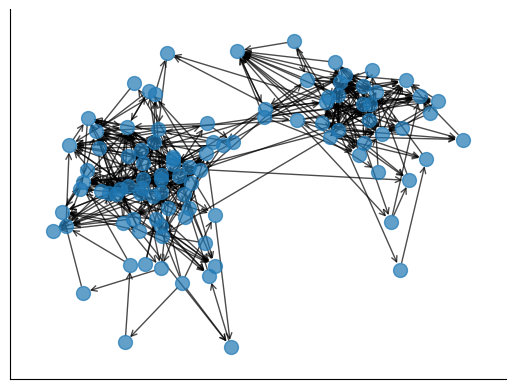

In [9]:
G= nx.from_edgelist(sm.Network_db["Time_{}".format(str(T-1))], create_using= nx.DiGraph)
pos = nx.spring_layout(G,  k = .4, iterations= 70)
#nodes_color = np.where(pd.DataFrame(sm.Opinions_db).T.loc["Time_{}".format(str(T-1))][list(G.nodes)] >0, "red", "blue")
nx.draw_networkx(G, pos = pos, alpha =.7, arrowstyle = "->", with_labels = False, node_size = 100)


In [1349]:
def plot(N,p, s):
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))
    axes = axes.flatten()
    pd.DataFrame(sm.Opinions_db).T.plot(figsize = (20,10), ax = axes[0])
    axes[0].legend().remove()
    axes[0].set_xlabel("Values")
    sns.heatmap(pd.DataFrame(sm.Opinions_db).sort_values(by = "Time_{}".format(str(T-1))), ax = axes[1])
    #axes[1].set_title("Baseline", fontsize = 26)
    axes[1].set_ylabel("Agent Id")
    axes[1].set_xlabel("Time steps")
    #axes[1].set_xticks(np.arange(10))
    axes[1].set_xticklabels([])
    #axes[1].set_title("Baseline Consensus", fontsize = 26)
    sns.histplot(pd.DataFrame(sm.Opinions_db)["Time_0"], bins = 10, ax = axes[2], kde= True)
    sns.histplot(pd.DataFrame(sm.Opinions_db)["Time_{}".format(str(T-1))], bins = 10, ax = axes[3], kde = True, color = "orange")
    plt.suptitle("N = {}, p = {}, s = {}".format(str(N), str(p), str(s)), y = .95, fontsize = 20)
    #plt.suptitle("Baseline (No Media)", y = .95, fontsize = 20)
    plt.show()

In [1350]:
eta = .4
p = .1
s = .2
N = 1
T = 10000
mix = True
effect_record= True
include_media= True
sm, md = sim(p, s, N, eta = eta, mix = mix, T = T, effect_record= effect_record, include_media= include_media)

100%|██████████| 10000/10000 [01:15<00:00, 132.47it/s]


In [1359]:
Ns = (1, 2, 3, 6)
Ps = [.1, .5, .9]
Ss = [.1, .5, .9]
eta = .4
T = 10000
mix = True ####
effect_record= False
include_media= True
data = {}
para = [(N, p, s) for N in Ns for p in Ps for s in Ss]
for i in tqdm(para):
    N, p, s = i 
    sm, md = sim(p, s, N, eta = eta, mix = mix, T = T, effect_record= effect_record, include_media= include_media)
    data[i] = [sm, md]  

 39%|███▉      | 14/36 [12:25<18:52, 51.47s/it]

In [149]:
pd.merge(sm.ME_db, sm.Message_db.reset_index(), on="index", how = "left")

,uid,Time,index,effects,original_poster,rt_poster,content,rt_status
0,52,6,1,False,mainstream_media,mainstream_media,-0.167275,False
1,6,7,3,True,63,63,-0.477246,False
2,9,10,6,True,15,15,-0.182823,False
3,17,12,5,True,63,6,-0.477246,True
4,17,12,6,True,15,15,-0.182823,False
...,...,...,...,...,...,...,...,...
54133,81,10000,10240,True,mainstream_media,50,0.231273,True
54134,81,10000,10241,True,86,86,-0.040569,False
54135,81,10000,10260,True,90,50,-0.153949,True
54136,81,10000,10283,True,86,86,-0.190864,False


In [135]:
name = "e5m3base"
sm.Opinions_db.to_csv(os.getcwd() + "/data/baseline/"+ name + "_opinion.csv")
#sm.Network_db.to_csv(os.getcwd() + "data/baseline/e5m3base.csv")
pd.DataFrame(sm.Network_db).to_csv(os.getcwd() + "/data/baseline/"+ name + "_network.csv")
sm.ME_db.to_csv(os.getcwd() + "/data/baseline/"+ name + "_me.csv")
    #sm.Message_db.to_csv(os.getcwd() + "/data/baseline/"+ name + "_message.csv")

In [35]:
#for c in np.linspace()
#sm = sim(T =T , eta = eta, miu= miu, prob_rewire = q, c = c, screen_size = l, mass_media_para = media_para, include_media= False, effect_record= True)
#media_para= [(40,60)]
rep = 10
for r in range(rep):
    name = "rep_" + str(r) + "/"
    new_dic = os.makedirs("./polarized2/"+name)
    for c in range(1, 100):
        sm = sim(T =T , eta = eta, miu= miu, prob_rewire = q, c = c, screen_size = l, mass_media_para = media_para, include_media =True, effect_record= True)
        #ms_e5m3[c] = sm
        #name = "e5m3c{}mainstream".format(str(c))
        sm.Opinions_db.to_csv("./polarized2/"+name+"c{}_opinion.csv".format(str(c)))
        #sm.Network_db.to_csv(os.getcwd() + "data/baseline/e5m3base.csv")
        pd.DataFrame(sm.Network_db).to_csv("./polarized2/"+name+"c{}_newtork.csv".format(str(c)))
        sm.ME_db.to_csv("./polarized2/"+name+"c{}_effect.csv".format(str(c)))
        sm.Message_db.to_csv("./polarized2/"+name+"c{}_message.csv".format(str(c)))

KeyboardInterrupt: 

In [169]:
pd.DataFrame(sm.Network_db["Time_9999"])

,0,1
0,0,40
1,30,93
2,30,42
3,30,72
4,30,22
...,...,...
394,89,39
395,91,73
396,91,81
397,91,4


In [190]:
with open("test.json", "w") as f:
        js.dump(sm.Network_db, f)

In [23]:
sm.Message_db.original_poster.value_counts()

64    235
36    214
33    198
4     177
49    175
     ... 
17     46
66     44
65     43
68     39
60     38
Name: original_poster, Length: 100, dtype: int64

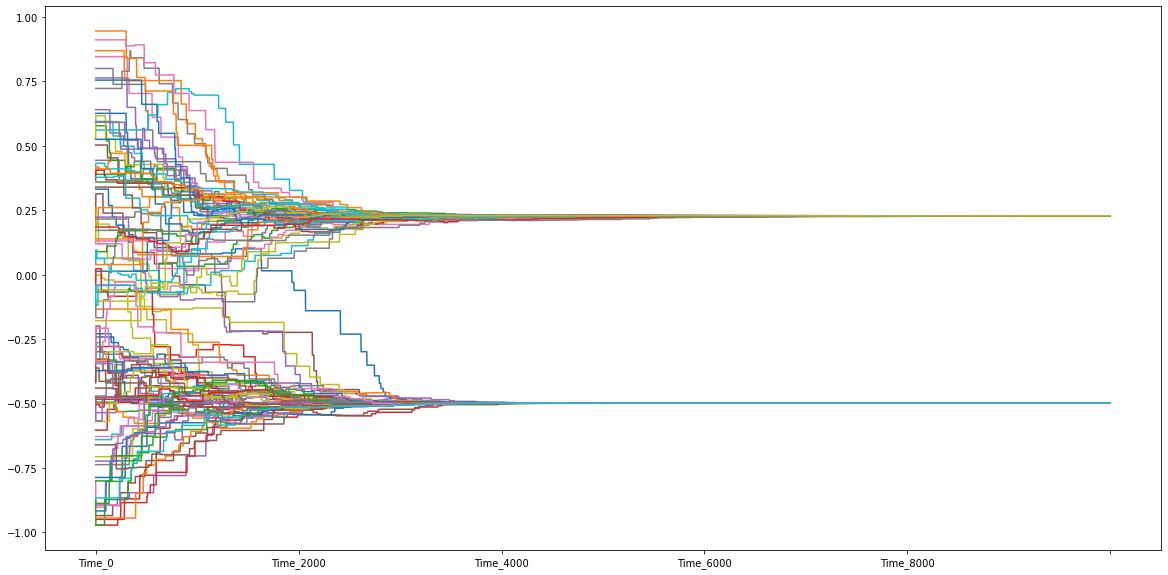

In [25]:
ax = sm.Opinions_db.T.plot(figsize = (20,10))
ax.legend().remove()

In [112]:
import json as js, os

In [50]:
dir = "/Volumes/GoogleDrive/My Drive/sim_media_effects"
#filename1 = os.listdir(data_dir)

In [56]:
len(np.floor(np.linspace(1, 300)))

50

In [182]:
Harreta = .6,
miu = .3
q = .3
T =10000
l = 7
c = 50
rep = 10
media_para = [(0, 20), (20, 40), (40,60), (60, 80), (80, 100)]
dir = "/Volumes/GoogleDrive/My Drive/sim_media_effects/five_media/"
for i in np.arange(3, rep):
    data_dir = dir+ "rep_"+str(i)
    os.makedirs(data_dir)
    for c in np.floor(np.linspace(1, 300)):
        c = int(c)
        #os.makedirs(data_dir+"\\Network\\")
        #os.makedirs(data_dir+"\\message\\")
        #os.makedirs(data_dir+"\\ME\\")
        sm = sim(T =T , eta = eta, miu= miu, prob_rewire = q, c = c, screen_size = l, mass_media_para = media_para, effect_record= True)
        #ms_e5m3[c] = sm
        sm.Opinions_db.to_csv(data_dir +"/Opinion_c{}.csv".format(str(c)))
        sm.Message_db.to_csv(data_dir +"/message_c{}.csv".format(str(c)))
        sm.ME_db.to_csv(data_dir +"/ME_c{}.csv".format(str(c)))
        #network_dir = data_dir +"\\Network\\"
        with open(data_dir + "/Network_c{}.json".format(str(c)), "w") as f:
            js.dump(sm.Network_db, f)
    #break

KeyboardInterrupt: 

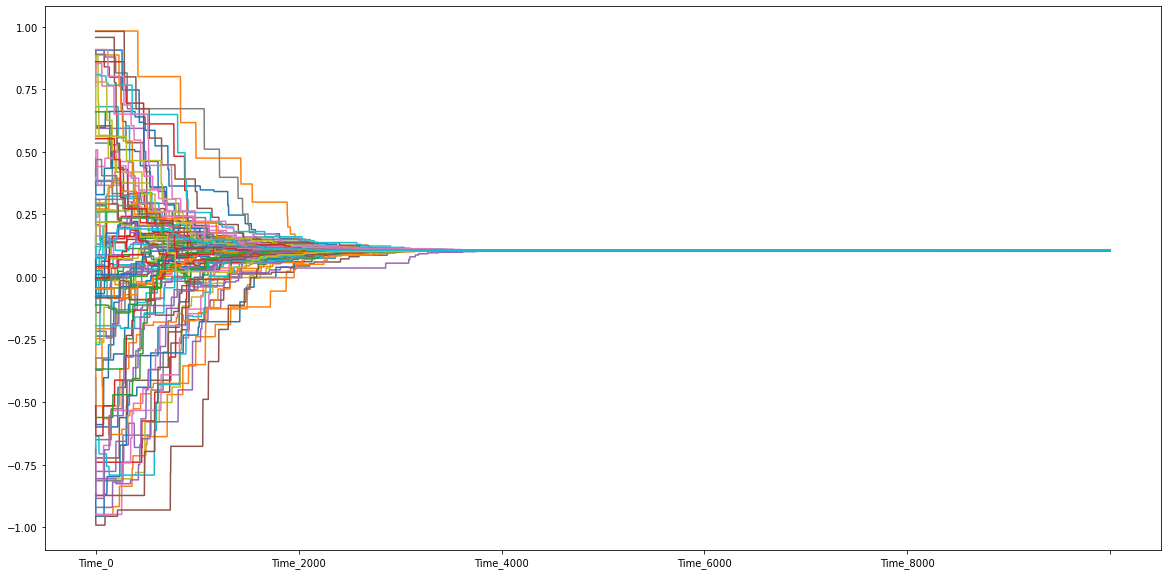

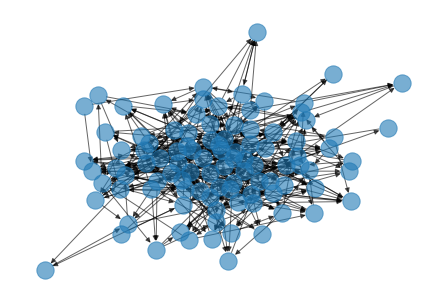

In [34]:
G= nx.from_edgelist(sm.Network_db["Time_0"], create_using= nx.DiGraph)
nx.draw(G, alpha = 0.6)

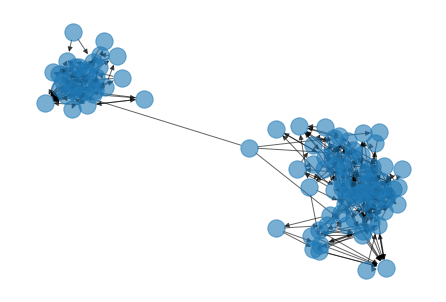

In [39]:
G = nx.from_edgelist(sm.Network_db["Time_9999"], create_using= nx.DiGraph)
pos = nx.spring_layout(G, k=0.15, iterations= 40)
#pos = nx.spiral_layout(G, eq)
nx.draw(G, pos = pos, alpha = 0.6)

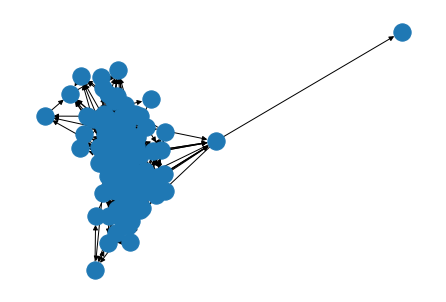

In [118]:
test = nx.from_edgelist(sm.Network_db["Time_9000"], create_using= nx.DiGraph)
nx.draw(test)

In [49]:
test = nx.from_edgelist(sm.Network_db["Time_0"], create_using= nx.DiGraph)
len(test.edges())

400

In [161]:
sm.make_screen(20, l = 7, include_media = True).reset_index()

,index,original_poster,rt_poster,content,rt_status
0,886,mass_media,mass_media,0.065294,False
1,894,mass_media,mass_media,0.066234,False
2,896,43,43,0.881775,False
3,902,52,52,0.086205,False
4,904,mass_media,mass_media,0.066627,False
5,915,mass_media,mass_media,0.066648,False
6,920,19,19,0.075204,False


In [18]:
parameters = np.around(np.linspace(0,1, 50), 2)
#MIU = np.linspace(0,1, 20)Q = np.linspace(0,1, 20)
T = 10000
reptition = 10
#q  = .3

In [158]:
sm.ME_db

,message_index,uid,fri_or_foe


In [126]:
screen.index

Int64Index([0, 0, 0, 0, 0, 0, 0], dtype='int64')

In [ ]:
class MassMedia():
    def __init__(self, cycle, P):
        self.c = cycle
        
    def mass_media_message(self, c, ):
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.mean(self.O[time])
            post = pd.DataFrame({"original_poster": ["mainstream_media"], "rt_poster": ["mainstream_media"], "content": [media_content], "rt_status":[False]})
            return post
    
    def liberal_media(self, t):
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.quantile(self.O[time], .10)
            post = pd.DataFrame({"original_poster": ["liberal_media"], "rt_poster": ["liberal_media"], "content": [media_content], "rt_status":[False]})
            return post
        
    def conservative_media(self, t):
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.quantile(self.O[time], .90)
            post = pd.DataFrame({"original_poster": ["conservative_media"], "rt_poster": ["conservative_media"], "content": [media_content], "rt_status":[False]})
            return post
        
    def any_media(self, t, n):
        if n <20:
            lab = "extreme_liberal_media"
        elif n<40:
            lab = "liberal_media"
        elif n< 60:
            lab = "mainstream_media"
        elif n<80:
            lab = "conservative_media"
        else:
            lab = "extreme_conservative_media"
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.percentile(self.O[time], n)
            post = pd.DataFrame({"original_poster": [lab], "rt_poster": [lab], "content": [media_content], "rt_status":[False]})
            return post

    def random_media(self, t, m=0, sd = .3):
        res = t % self.c
        if res == 0:
            v = np.random.choice(np.random.normal(m, sd, 1000))
            if v <-1:
                v = -1
            if v >1:
                v = 1
            if v <-.6:
                lab = "extreme_liberal_media"
            elif v<-.2:
                lab = "liberal_media"
            elif v< .2:
                lab = "mainstream_media"
            elif v<.6:
                lab = "conservative_media"
            else:
                lab = "extreme_conservative_media" 
            post = pd.DataFrame({"original_poster": [lab], "rt_poster": [lab], "content": [v], "rt_status":[False]}) 
            return post  